In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reload_ext autoreload
%autoreload 2             
%matplotlib inline     

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 169kB/s 
     |████████████████████████████████| 92kB 13.6MB/s 
     |████████████████████████████████| 460kB 55.8MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from konlpy.tag import Okt
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')

1 Physical GPUs, 1 Logical GPU


In [ ]:
# train = pd.read_csv(trn_file, index_col=0)
train = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/news_train.csv", index_col=0)
train.head()

,date,title,content,ord,info
n_id,,,,,
NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0


In [ ]:
test = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/news_test.csv", index_col=0)
test.head()

,date,title,content,ord,id
n_id,,,,,
NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1
NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2
NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3
NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4
NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5


In [ ]:
# def alpha_num(text):
#     return re.sub(r'[^A-Za-z0-9 ]', '', text)

    
tokenizer = Okt()
def text_preprocessing(text,tokenizer):
    
    stopwords = ['을', '를', '이', '가', '은', '는']
    
    txt = re.sub('[^가-힣a-z]', ' ', text)
    token = tokenizer.morphs(txt)
    token = [t for t in token if t not in stopwords]
        
    return token

ex_text = "이번에 새롭게 개봉한 영화의 배우들은 모두 훌륭한 연기력과 아름다운 목소리를 갖고 있어!!"
example_pre= text_preprocessing(ex_text, tokenizer)

print(example_pre)

['이번', '에', '새롭게', '개봉', '한', '영화', '의', '배우', '들', '모두', '훌륭한', '연기력', '과', '아름다운', '목소리', '갖고', '있어']


In [ ]:
def text_preprocessing(text_list):
    
    stopwords = ['을', '를', '이', '가', '은', '는', 'null'] #불용어 설정
    tokenizer = Okt() #형태소 분석기 
    token_list = []
    
    for text in text_list:
        txt = re.sub('[^가-힣a-z]', ' ', text) #한글과 영어 소문자만 남기고 다른 글자 모두 제거
        token = tokenizer.morphs(txt) #형태소 분석
        print(token)
        # token = [t for t in token if t not in stopwords or type(t) != float] #형태소 분석 결과 중 stopwords에 해당하지 않는 것만 추출
        token = [t for t in token if t not in stopwords]
        print(token)
        token_list.append(token)
        
    return token_list, tokenizer


In [ ]:
tokenizer = Okt()
#형태소 분석기를 따로 저장한 이유는 후에 test 데이터 전처리를 진행할 때 이용해야 되기 때문입니다. 
train10000 = train['content'][:10000]
test10000 = test['content'][:10000]
testAll =  test['content']
print(test10000[:10])

trn_tokenlist, okt = text_preprocessing(train10000) 
tst_tokenlist, okt = text_preprocessing(testAll) 

X_train = np.array(trn_tokenlist)
X_test = np.array(tst_tokenlist)
y = train['info'][:10000].values



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['수익', '을', '로', '만들어', '준다고', '영웅', '스', '탁론', '이', '라면', '가능', '효과', '적', '인', '레버리지', '를', '이용', '하여', '수익률', '을', '배', '로']
['수익', '로', '만들어', '준다고', '영웅', '스', '탁론', '라면', '가능', '효과', '적', '인', '레버리지', '이용', '하여', '수익률', '배', '로']
['수익', '을', '로', '만들어', '준다고', '영웅', '스', '탁론', '이', '라면', '가능', '효과', '적', '인', '레버리지', '를', '이용', '하여', '수익률', '을', '배', '로']
['수익', '로', '만들어', '준다고', '영웅', '스', '탁론', '라면', '가능', '효과', '적', '인', '레버리지', '이용', '하여', '수익률', '배', '로']
['오늘', '사면', '내일', '터지는', '상한', '가', '무료', '공개']
['오늘', '사면', '내일', '터지는', '상한', '무료', '공개']
['오늘', '사면', '내일', '터지는', '상한', '가', '무료', '공개']
['오늘', '사면', '내일', '터지는', '상한', '무료', '공개']
['저', '평가', '실적', '재료', '받쳐주는', '바이오', '대장', '년', '한', '종목', '으로', '끝']
['저', '평가', '실적', '재료', '받쳐주는', '바이오', '대장', '년', '한', '종목', '으로', '끝']
['저', '평가', '실적', '재료', '받쳐주는', '바이오', '대장', '년', '한', '종목', '으로', '끝']
['저', '평가', '실적', '재료', '받쳐주는', '바이오', '대장', '년', '한', '종목', '으로', '끝']
['업계', '최저', '금리',

In [ ]:
print(X_train.shape, X_test.shape)
print(X_train[:10])
print(X_test[:10])

(10000,) (142565,)
[list(['이데일리', '현재', '코스닥', '기관', '억', '순', '매도'])
 list(['실적', '기반', '저가', '에', '매집', '해야', '할', '월', '급등', '유망', '주', '전격', '공개'])
 list(['하', '이스', '탁론', '선취', '수수료', '없는', '월', '최저', '금리', '상품', '출시'])
 list(['종합', '경제', '정보', '미디어', '이데일리', '무단', '전', '재', '재', '배포', '금지'])
 list(['전국', '적', '인', '소비', '붐', '조성', '에', '기여', '할', '예정'])
 list(['이데일리', '권오석', '기자', '중소', '벤처기업', '부', '이하', '중', '기부', '대한민국', '동행', '세', '일', '에', '개', '홈쇼핑', '사가', '홍보', '와', '판매', '에', '동참', '한다고', '일', '밝혔다'])
 list(['대한민국', '동행', '세', '일', '라이브', '커머스', '언택트', '콘서트', '행사', '연', '계', '등', '비', '대면', '이라는', '새로운', '형태', '의', '소비', '촉진', '행사', '다'])
 list(['개', '권역', '에서의', '현장', '행사', '와', '온', '오프라인', '판촉', '홈쇼핑', '등', '연', '계', '행사', '통해', '소비', '심리', '진작', '하기', '위함', '이다'])
 list(['이번', '동행', '세', '일', '에서는', '롯데', '공영', '현대', '홈앤쇼핑', '등', '개', '홈쇼핑', '사가', '동행', '세', '일', '의', '홍보', '와', '방송', '판매', '에', '동참', '해', '전국', '적', '인', '소비', '붐', '조성', '에', '기여', '한', '다'])
 list([

In [ ]:
y = train['info'][:10000].values


In [ ]:
X_train[:3]
X_test[:3]

array([list(['마이크로', '장비', '양산', '돌입', '전방', '업체', '투자', '확대', '로', '본업', '도', '호조', '연일', '신고']),
       list(['이데일리', '김대웅', '기자', '반도체', '장비', '업체', '코세', '스', '의', '기술', '력', '마이크로', '발광다이오드', '시대', '앞두고', '주목', '받고', '있습니다']),
       list(['최근', '대형', '업체', '들', '과', '거래', '맺고', '관련', '장비', '들', '의', '양산', '에', '돌입', '하면서', '주가', '도', '연일', '신', '고가', '달리', '고', '있습니다'])],
      dtype=object)

In [ ]:
y[:3]

array([0, 1, 1])

In [ ]:
feature_dir = Path('/content/drive/My Drive/AI 진짜 뉴스/feature')
val_dir = Path('/content/drive/My Drive/AI 진짜 뉴스/val')
tst_dir = Path('/content/drive/My Drive/AI 진짜 뉴스/tst')
sub_dir = Path('/content/drive/My Drive/AI 진짜 뉴스/sub')
dirs = [feature_dir, val_dir, tst_dir, sub_dir]
for d in dirs:
    os.makedirs(d, exist_ok=True)

In [ ]:
algo_name = 'cnn'
feature_name = 'emb'
PATH = '/content/drive/My Drive/AI 진짜 뉴스/result'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [ ]:
n_fold = 5
n_class = 2
seed = 42
vocab_size = 20000
embedding_dim = 128
max_length = 64
padding_type='post'

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(word_index)

{'에': 1, '의': 2, '으로': 3, '한': 4, '했다': 5, '월': 6, '로': 7, '할': 8, '일': 9, '등': 10, '에서': 11, '것': 12, '과': 13, '재': 14, '수': 15, '전': 16, '들': 17, '이데일리': 18, '하는': 19, '이다': 20, '적': 21, '와': 22, '주': 23, '해': 24, '도': 25, '있다': 26, '하고': 27, '인': 28, '경제': 29, '정보': 30, '다': 31, '코로나': 32, '년': 33, '공개': 34, '급등': 35, '실적': 36, '해야': 37, '상품': 38, '하': 39, '만': 40, '종합': 41, '투자': 42, '출시': 43, '유망': 44, '금지': 45, '없는': 46, '금리': 47, '미디어': 48, '배포': 49, '무단': 50, '기반': 51, '최저': 52, '기자': 53, '수수료': 54, '선취': 55, '종목': 56, '이스': 57, '매집': 58, '탁론': 59, '저가': 60, '전격': 61, '명': 62, '있는': 63, '원': 64, '까지': 65, '고': 66, '된': 67, '말': 68, '억원': 69, '기업': 70, '및': 71, '위': 72, '시장': 73, '중': 74, '대': 75, '시': 76, '밝혔다': 77, '통해': 78, '확인': 79, '관련': 80, '만원': 81, '부터': 82, '한다': 83, '개': 84, '대한': 85, '사업': 86, '이라고': 87, '수익': 88, '한국': 89, '될': 90, '지': 91, '제': 92, '대비': 93, '위해': 94, '내': 95, '지역': 96, '성': 97, '지원': 98, '장': 99, '억': 100, '신청': 101, '하기': 102, '이번': 103, '됐다': 104

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(train_sequences[:3])
print(test_sequences[:3])

[[18, 128, 697, 238, 100, 208, 506], [36, 51, 60, 1, 58, 37, 8, 6, 35, 44, 23, 61, 34], [39, 57, 59, 55, 54, 46, 6, 52, 47, 38, 43]]
[[4854, 604, 1432, 2535, 2879, 186, 42, 150, 7, 1834, 25, 2772, 3642, 960], [18, 53, 498, 604, 186, 746, 2, 146, 417, 4854, 8656, 972, 1294, 781, 593, 245], [147, 1119, 186, 17, 13, 176, 7054, 80, 604, 17, 2, 1432, 1, 2535, 290, 131, 25, 3642, 162, 2225, 2173, 66, 245]]


In [ ]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(10000, 64) (142565, 64)


In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [ ]:
def get_model():
    # model = Sequential([
    #     Embedding(vocab_size, embedding_dim, input_length=max_length),
    #     Dropout(.5),
    #     Conv1D(2, 7, padding="valid", activation="relu", strides=3),
    #     Conv1D(2, 7, padding="valid", activation="relu", strides=3),    
    #     GlobalMaxPooling1D(),
    #     Dense(2, activation='relu'),
    #     Dropout(.5),
    #     Dense(n_class, activation='relu')
    # ])
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Dropout(.5),
        Conv1D(128, 7, padding="valid", activation="relu", strides=3),
        Conv1D(128, 7, padding="valid", activation="relu", strides=3),    
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(.3), 
        Dense(n_class, activation='softmax')
    ])
    
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.005))
    return model

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
# print(p_val.shape, p_tst.shape)

for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    # print("i_trn : ", i_trn)
    # print("i_val : ", i_val)
    print(y)
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)


    clf = get_model()    
    clf.fit(trn[i_trn],
          to_categorical(y[i_trn]),
          validation_data=(trn[i_val], to_categorical(y[i_val])),
          epochs=10,
          batch_size=512,
          callbacks=[es])
    

    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold


[0 1 1 ... 0 0 0]
training model for CV #1
Epoch 1/10
16/16 [==============================] - 1s 48ms/step - loss: 0.3508 - val_loss: 0.1957
Epoch 2/10
16/16 [==============================] - 1s 43ms/step - loss: 0.1489 - val_loss: 0.1492
Epoch 3/10
16/16 [==============================] - 1s 43ms/step - loss: 0.0429 - val_loss: 0.0919
Epoch 4/10
16/16 [==============================] - 1s 41ms/step - loss: 0.0062 - val_loss: 0.1161
Epoch 5/10
16/16 [==============================] - 1s 42ms/step - loss: 0.0014 - val_loss: 0.0861
Epoch 6/10
16/16 [==============================] - 1s 43ms/step - loss: 7.5831e-04 - val_loss: 0.0971
Epoch 7/10
16/16 [==============================] - 1s 44ms/step - loss: 3.6474e-04 - val_loss: 0.1117
Epoch 8/10
16/16 [==============================] - 1s 43ms/step - loss: 3.8220e-04 - val_loss: 0.1106
Epoch 00008: early stopping
[0 1 1 ... 0 0 0]
training model for CV #2
Epoch 1/10
16/16 [==============================] - 1s 47ms/step - loss: 0.3711 - 

In [ ]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Accuracy (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  98.7300%
Accuracy (CV):   0.0909


In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [ ]:
print(clf.summary())

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 64, 128)           2560000   
_________________________________________________________________
dropout_72 (Dropout)         (None, 64, 128)           0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 20, 128)           114816    
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5, 128)            114816    
_________________________________________________________________
global_max_pooling1d_36 (Glo (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_73 (Dropout)         (None, 128)             

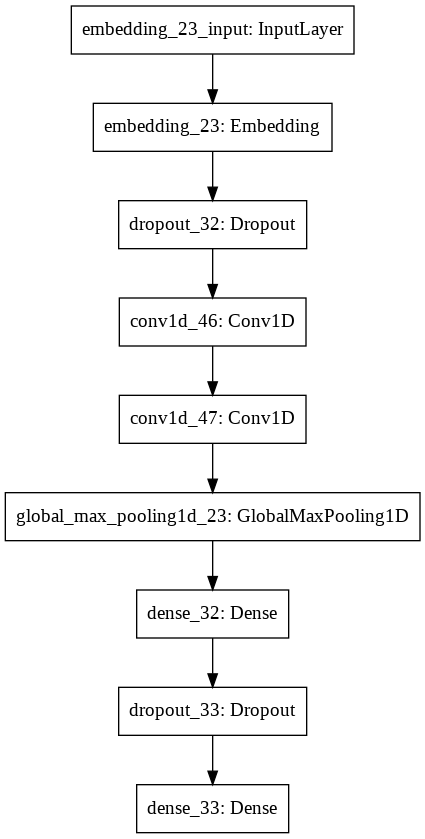

In [ ]:
plot_model(clf)

In [ ]:
test = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/news_test.csv")
sample_submission = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/sample_submission.csv")

X = train['content'][:10000].values
Y =  train['info'].values
pred_test = clf.predict(X)
sample_submission.loc[:,'info'] = np.where(pred_test> 0.5, 1,0).reshape(-1)

ValueError: ignored

In [ ]:
from pathlib import Path
import os

# sub = pd.read_csv(sample_file, index_col=0)
# print(sub.shape)
# sub.head()
algo_name = 'cnn'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

sub = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/sample_submission.csv", index_col=0)
sub = sub[:10000]
# print(sub.shape)
print(sub.head())

sub_dir = Path('/content/drive/My Drive/AI 진짜 뉴스/result')
sub_file = sub_dir / f'{model_name}.csv'

             info
id               
NEWS00237_1     0
NEWS00237_2     0
NEWS00237_3     0
NEWS00237_4     0
NEWS00237_5     0


In [ ]:
print(p_tst.shape)

sub[sub.columns] = p_tst
sub.head()



(10000, 1)


,info
id,
NEWS00237_1,0.0
NEWS00237_2,0.0
NEWS00237_3,0.0
NEWS00237_4,0.0
NEWS00237_5,0.0


In [ ]:
sub.to_csv(sub_file)